# 多臂老虎机问题

多臂老虎机，每一臂都有其收益的均值。如果想赢得最多的钱，最朴素的做法是先通过实现找出收益均值最多的臂，然后只选择该臂即可。

每一次选择都是独立的，但是选择之前需要权衡 exploration 与 exploitation。前者尽可能地进行随机尝试，后者则选择“当前”均值最多的臂。

In [1]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10
probs = np.random.rand(n)
eps = 0.2 # epsilon for epsilon-greedy selection

老虎机的每个臂的奖励分布实现如下。每个臂的收益概率作为入参，比如概率是 0.7，由于在这个问题里，设定最大收益为 10，那么在 0.7 的概率下，理应得到接近 7 的收益，所以在下面的实验验证里，选择 2000 次该臂，得到的平均收益正是 7。

In [2]:
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [3]:
np.mean([get_reward(0.7) for _ in range(2000)])

7.0135

理论上我们需要将每次操作的选择与收益记录成 `(action, reward)` 对，但在这个问题里，我们做选择的时候是根据过往收益的均值来进行的，所以我们只要一直保持对均值的更新即可，并不需要将每次结果记录下来。为了保持对均值的更新，我们需要记录每个臂的选择次数，以及其最新的收益均值。

In [5]:
record = np.zeros((n, 2))
record

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [6]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

In [7]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis=0)
    return arm_index

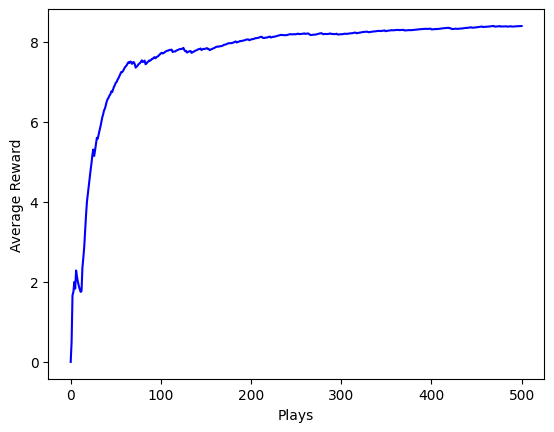

In [14]:
record = np.zeros((n, 2))
probs = np.random.rand(n)
eps = 0.2
episodes = 500
# track mean rewards
rewards = [0]

for i in range(episodes):
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(n)

    r = get_reward(probs[choice])
    record = update_record(record, choice, r)
    mean_reward = ((i + 1) * rewards[-1] + r) / (i + 2)
    rewards.append(mean_reward)

plt.xlabel('Plays')
plt.ylabel('Average Reward')
plt.plot(np.arange(len(rewards)), rewards, 'b', label='Mean Rewards')